In [1]:
import warnings
warnings.filterwarnings("ignore")
import keras
from confusion_matrix import CM
from numpy.lib.scimath import log
from scipy.special import binom
import operator as op
from functools import reduce
import numpy as np
import math 
from scipy.special import factorial
from scipy.stats import nbinom
import matplotlib.pyplot as plt

from keras import models, optimizers, layers
from keras import backend as K
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Layer, Dense, Embedding,TimeDistributed,Conv2D,Input, Flatten,Reshape ,MaxPooling2D, Dropout,Activation, LSTM, Bidirectional, Lambda
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
from keras import callbacks
from keras import initializers, layers

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from keras.callbacks import ReduceLROnPlateau
from functools import partial
from bayes_opt import BayesianOptimization

Using TensorFlow backend.


In [2]:
images = np.load('/home/yi/forest/hardness/np/pressure_1.npy')
liju = np.load('/home/yi/forest/hardness/np/torque_1.npy')
finger1 = images[:,::6,:24]
finger2 = images[:,::6,24:48]
finger3 = images[:,::6,48:]
time_steps = 12
fg1 = finger1[:,:].reshape((780, time_steps, 8, 3))
fg2 = finger2[:,:].reshape((780, time_steps, 8, 3))
fg3 = finger3[:,:].reshape((780, time_steps, 8, 3))
fgall = np.concatenate((fg1, fg3, fg2), axis=-1)

liju_bet = liju[:,::6,:]

liju_arr = np.concatenate((liju_bet, liju_bet, liju_bet), axis=-1)
liju_exp = np.expand_dims(liju_arr, axis=-2)
X = np.concatenate((fgall, liju_exp), axis=-2)
X = np.expand_dims(X, axis=-1)

In [3]:
cats_nums = 13
y_ohot = np.repeat(np.arange(cats_nums), 60)
np.random.seed(42)
shuffle_indices = np.random.permutation(np.arange(len(y_ohot)))

X = X[shuffle_indices]
y = y_ohot[shuffle_indices]

generalize one-hot encoding (ground truth) using Poisson distribution.

In [4]:
def softmax(x):
    return (np.exp(x, dtype=float) / np.sum(np.exp(x, dtype=float), axis=0, dtype=float)).astype(float)

def Poss_true(y,e):
    
    y_po = np.zeros((len(y),13))
    
    k = np.arange(1,14,1)

    
    for i in range(len(y)):
        n = np.sqrt((y[i]+1)*(y[i]+2))
        y_po[i] = k*log(n) - n - log(factorial(k))
        
        y_po[i] = y_po[i]
        
        y_po[i] = softmax(y_po[i]/e)
    
    return y_po

In [5]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=4)

In [6]:
def create_model(dr, es):
    
    K.set_learning_phase(1)
    acc_per_fold = []
    loss_per_fold = []
    train_accur_per_fold = []
    test_accur_per_fold = []
    train_loss_per_fold = []
    test_loss_per_fold = []
    cm_data_per_fold = []
    pred_per_fold = []
    y_test_per_fold = []

    fold_no = 1
    es = int(es)
    class MyLoss(Layer):
        def __init__(self, var1):
            super(MyLoss, self).__init__()
            self.var1 = K.variable(var1) 


        def get_vars(self):
            return self.var1

        def custom_loss(self, y_true, y_pred):
            return self.var1 * K.mean(K.square(y_true-y_pred))

        def call(self, y_true, y_pred):
            self.add_loss(self.custom_loss(y_true, y_pred))
            return y_pred

    for train, test in kfold.split(X, y):
        model1 = Sequential()

        model1.add(layers.Conv2D(filters=32, kernel_size=6,strides=1, padding='same', activation='relu', name='cl_conv1', 
                  input_shape=[9, 9, 1]))

        model1.add(layers.BatchNormalization())
        model1.add(layers.Activation('relu'))

        model1.add(MaxPooling2D(pool_size=2,strides=2, padding='same', name='cl_maxpool1'))

        model1.add(layers.Conv2D(filters=64, kernel_size=6,strides=1, padding='same', activation='relu', name='cl_conv2'))
        model1.add(layers.BatchNormalization())
        model1.add(layers.Activation('relu'))

        model1.add(layers.MaxPooling2D(pool_size=2,strides=2, padding='same', name='cl_maxpool2'))
        model1.add(Flatten())
   

        model2 = Sequential()
        model2.add(TimeDistributed(model1,input_shape = (12,9,9,1)))

        model2.add(LSTM(units=100, name="lstm_out"))
       
        model2.add(Dense(units=13,  name="Dense", activation='softmax'))
        
       
        alpha = K.variable(0.2)
        
        class NewCallback(keras.callbacks.Callback):
            def __init__(self, alpha):
                self.alpha = alpha       
            def on_epoch_end(self, epoch, logs={}):
                K.set_value(self.alpha, K.get_value(self.alpha)**dr)#0,99
        
        def custom_loss(alpha):
            
            def loss(y_true, y_pred,**kwargs):

            #weights = tf.constant(np.arange(0,13,1), dtype=tf.float32)
            #y_class = K.argmax(y_true, axis=1)
            #w = tf.gather(weights, y_class)
                y_true = y_true / alpha
                y_true = K.softmax(y_true)
                return keras.losses.categorical_crossentropy(y_true, y_pred)
                
            return loss
        
        early_stop = callbacks.EarlyStopping(monitor='val_accuracy', mode='max',patience=es)
        reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.70434, patience=10, mode='max')
        model2.compile(loss=custom_loss(alpha),optimizer=optimizers.RMSprop(lr=0.001), metrics = ["accuracy"])#QWK loss
        tf.logging.set_verbosity(tf.logging.ERROR)

        y_true = to_categorical(y[train], cats_nums)
        
               
        y_tr = Poss_true(y[train],0.2)
        y_ts = Poss_true(y[test],0.2)

        history = model2.fit(X[train], y_tr, batch_size=30, nb_epoch=100,verbose=1,validation_data=(X[test], y_ts), callbacks=[reduce_lr, early_stop])

        train_accur_per_fold.append(history.history["acc"])
        test_accur_per_fold.append(history.history["val_acc"])
        train_loss_per_fold.append(history.history["loss"])
        test_loss_per_fold.append(history.history["val_loss"])

        scores = model2.evaluate(X[test], y_ts, verbose=1)
        print(f'Score for fold {fold_no}: {model2.metrics_names[0]} of {scores[0]}; {model2.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])

        pred = model2.predict(X[test])
        pred_per_fold.append(pred)
        y_test_per_fold.append(y[test])
        cm_data = confusion_matrix(y_ts.argmax(axis=1), pred.argmax(axis=1))
        cm_data_per_fold.append(cm_data)
        fold_no = fold_no + 1

    train_acc = np.mean(train_accur_per_fold, axis = 0)
    test_acc = np.mean(test_accur_per_fold, axis = 0)
    train_loss = np.mean(train_loss_per_fold, axis = 0)
    test_loss = np.mean(test_loss_per_fold, axis = 0)
    cm_data = np.sum(cm_data_per_fold, axis=0)

    acc = np.mean(np.array(acc_per_fold))
    

    name = "fa_0.70434_pa_10_dr_" + str(dr)+ "es_" + str(es)
    train_test_acc_loss = np.concatenate((np.expand_dims(train_acc, axis=-1), 
                    np.expand_dims(test_acc, axis=-1), 
                    np.expand_dims(train_loss, axis=-1),
                    np.expand_dims(train_loss, axis=-1)), axis=-1)

    path = "/home/yi/forest/hardness/paper_code/Acc/result1/data_shape1/"
    np.save(path + 'pred/'+name + '.npy', np.array(pred_per_fold))
    np.save(path + 'y_test/'+name + '.npy', np.array(y_test_per_fold))
    np.save(path + 'train_test_acc_loss/'+name + '.npy', train_test_acc_loss) 
    np.save(path + 'cm_data/'+name + '.npy', cm_data)
    np.save(path + 'final_acc/'+name + '.npy', np.array(acc_per_fold))
    CM(cm_data, name)
    
    return acc

In [2]:
780*3

2340

|   iter    |  target   |    dr     |    es     |
-------------------------------------------------




Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Train on 702 samples, validate on 78 samples
Epoch 1/100
702/702 [==============================] - 2s 3ms/step - loss: 2.4779 - acc: 0.2735 - val_loss: 2.4714 - val_acc: 0.3590
Epoch 2/100
702/702 [==============================] - 1s 1ms/step - loss: 2.3133 - acc: 0.5499 - val_loss: 2.2756 - val_acc: 0.6923
Epoch 3/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2476 - acc: 0.7379 - val_loss: 2.2540 - val_acc: 0.7179
Epoch 4/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2140 - acc: 0.8533 - val_loss: 2.2494 - val_acc: 0.7051
Epoch 5/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2073 - acc: 0.8761 - val_loss: 2.2372 - val_acc: 0.7949
Epoch 6/100
702/702 [=================

Epoch 7/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1900 - acc: 0.9387 - val_loss: 2.1903 - val_acc: 0.9615
Epoch 8/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1844 - acc: 0.9601 - val_loss: 2.1846 - val_acc: 0.9487
Epoch 9/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1840 - acc: 0.9558 - val_loss: 2.1844 - val_acc: 0.8974
Epoch 10/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1780 - acc: 0.9758 - val_loss: 2.1912 - val_acc: 0.8462
Epoch 11/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1771 - acc: 0.9672 - val_loss: 2.1909 - val_acc: 0.8974
Epoch 12/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1794 - acc: 0.9658 - val_loss: 2.1766 - val_acc: 0.9872
Epoch 13/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1722 - acc: 0.9843 - val_loss: 2.1763 - val_acc: 0.9615
Epoch 14/100
702/702 [==============================] - 1s 1ms/st

702/702 [==============================] - 1s 1ms/step - loss: 2.1713 - acc: 0.9929 - val_loss: 2.1844 - val_acc: 0.9744
Epoch 29/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1684 - acc: 0.9972 - val_loss: 2.1731 - val_acc: 1.0000
Epoch 30/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1697 - acc: 0.9886 - val_loss: 2.1826 - val_acc: 0.9744
Epoch 31/100
702/702 [==============================] - 1s 2ms/step - loss: 2.1679 - acc: 0.9986 - val_loss: 2.1786 - val_acc: 0.9872
Epoch 32/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1674 - acc: 0.9972 - val_loss: 2.1807 - val_acc: 0.9872
Epoch 33/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1673 - acc: 0.9986 - val_loss: 2.1745 - val_acc: 0.9744
Epoch 34/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1679 - acc: 0.9972 - val_loss: 2.1796 - val_acc: 0.9872
Epoch 35/100
702/702 [==============================] - 1s 1ms/step - loss:

702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1683 - val_acc: 0.9744
Epoch 50/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1680 - val_acc: 1.0000
Epoch 51/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1681 - val_acc: 0.9872
Epoch 52/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1683 - val_acc: 0.9872
Epoch 53/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1686 - val_acc: 0.9872
Epoch 54/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1705 - val_acc: 0.9872
Epoch 55/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1683 - val_acc: 0.9872
Epoch 56/100
702/702 [==============================] - 1s 1ms/step - loss:

702/702 [==============================] - 1s 1ms/step - loss: 2.1891 - acc: 0.9302 - val_loss: 2.2019 - val_acc: 0.8974
Epoch 10/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1781 - acc: 0.9687 - val_loss: 2.2213 - val_acc: 0.8333
Epoch 11/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1831 - acc: 0.9558 - val_loss: 2.2023 - val_acc: 0.8590
Epoch 12/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1765 - acc: 0.9772 - val_loss: 2.1837 - val_acc: 0.9359
Epoch 13/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1854 - acc: 0.9459 - val_loss: 2.1920 - val_acc: 0.8974
Epoch 14/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1747 - acc: 0.9786 - val_loss: 2.1787 - val_acc: 0.9744
Epoch 15/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1723 - acc: 0.9815 - val_loss: 2.2230 - val_acc: 0.8077
Epoch 16/100
702/702 [==============================] - 1s 1ms/step - loss:

702/702 [==============================] - 1s 1ms/step - loss: 2.1678 - acc: 0.9972 - val_loss: 2.1723 - val_acc: 0.9872
Epoch 31/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1676 - acc: 0.9972 - val_loss: 2.1916 - val_acc: 0.8974
Epoch 32/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1680 - acc: 0.9943 - val_loss: 2.1710 - val_acc: 0.9872
Epoch 33/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1673 - acc: 0.9986 - val_loss: 2.1714 - val_acc: 0.9872
Epoch 34/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1669 - acc: 0.9986 - val_loss: 2.1716 - val_acc: 0.9872
Epoch 35/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1668 - acc: 0.9986 - val_loss: 2.1714 - val_acc: 0.9872
Epoch 36/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1668 - acc: 0.9986 - val_loss: 2.1701 - val_acc: 0.9872
Epoch 37/100
702/702 [==============================] - 1s 1ms/step - loss:

702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1761 - val_acc: 0.9744
Epoch 52/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1763 - val_acc: 0.9744
Epoch 53/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1758 - val_acc: 0.9744
Epoch 54/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1766 - val_acc: 0.9615
Epoch 55/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1765 - val_acc: 0.9744
Epoch 56/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1761 - val_acc: 0.9744
Epoch 57/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1794 - val_acc: 0.9744
Epoch 58/100
702/702 [==============================] - 1s 1ms/step - loss:

702/702 [==============================] - 1s 1ms/step - loss: 2.1793 - acc: 0.9573 - val_loss: 2.1912 - val_acc: 0.8846
Epoch 12/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1745 - acc: 0.9801 - val_loss: 2.1891 - val_acc: 0.9231
Epoch 13/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1804 - acc: 0.9558 - val_loss: 2.2007 - val_acc: 0.9231
Epoch 14/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1733 - acc: 0.9858 - val_loss: 2.1956 - val_acc: 0.8974
Epoch 15/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1774 - acc: 0.9786 - val_loss: 2.1819 - val_acc: 0.9359
Epoch 16/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1749 - acc: 0.9786 - val_loss: 2.1833 - val_acc: 0.9615
Epoch 17/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1708 - acc: 0.9886 - val_loss: 2.1887 - val_acc: 0.8846
Epoch 18/100
702/702 [==============================] - 1s 1ms/step - loss:

702/702 [==============================] - 1s 1ms/step - loss: 2.1669 - acc: 0.9986 - val_loss: 2.1796 - val_acc: 0.9615
Epoch 33/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1675 - acc: 0.9943 - val_loss: 2.1792 - val_acc: 0.9615
Epoch 34/100
702/702 [==============================] - 1s 2ms/step - loss: 2.1683 - acc: 0.9957 - val_loss: 2.1784 - val_acc: 0.9615
Epoch 35/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1673 - acc: 0.9986 - val_loss: 2.1779 - val_acc: 0.9744
Epoch 36/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1666 - acc: 1.0000 - val_loss: 2.1777 - val_acc: 0.9744
Epoch 37/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1666 - acc: 1.0000 - val_loss: 2.1791 - val_acc: 0.9615
Epoch 38/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1667 - acc: 0.9986 - val_loss: 2.1792 - val_acc: 0.9615
Epoch 39/100
702/702 [==============================] - 1s 1ms/step - loss:

702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1708 - val_acc: 0.9744
Epoch 54/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1666 - acc: 1.0000 - val_loss: 2.1699 - val_acc: 0.9744
Epoch 55/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1698 - val_acc: 0.9744
Epoch 56/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1698 - val_acc: 0.9744
Epoch 57/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1697 - val_acc: 0.9744
Epoch 58/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1697 - val_acc: 0.9744
Epoch 59/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1702 - val_acc: 0.9744
Epoch 60/100
702/702 [==============================] - 1s 1ms/step - loss:

<Figure size 432x288 with 0 Axes>

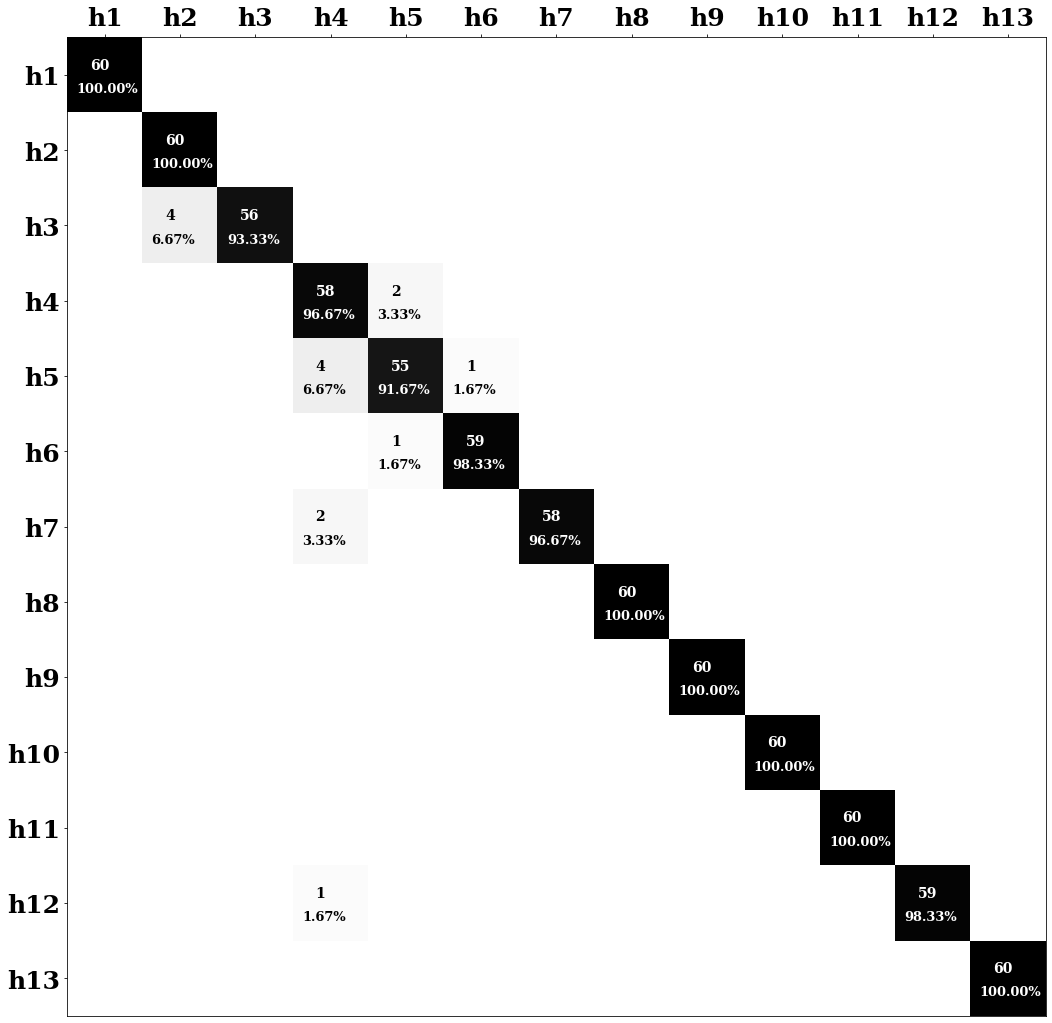

|  1        |  98.08    |  0.9413   |  10.04    |
Train on 702 samples, validate on 78 samples
Epoch 1/100
702/702 [==============================] - 3s 5ms/step - loss: 2.4779 - acc: 0.3205 - val_loss: 2.3993 - val_acc: 0.3077
Epoch 2/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2948 - acc: 0.6068 - val_loss: 2.2496 - val_acc: 0.7564
Epoch 3/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2462 - acc: 0.7650 - val_loss: 2.2518 - val_acc: 0.7436
Epoch 4/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2235 - acc: 0.8348 - val_loss: 2.2274 - val_acc: 0.8333
Epoch 5/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2036 - acc: 0.8590 - val_loss: 2.2051 - val_acc: 0.8462
Epoch 6/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1960 - acc: 0.9088 - val_loss: 2.2000 - val_acc: 0.8974
Epoch 7/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1929 - acc: 0.9359 - val_loss:

702/702 [==============================] - 1s 1ms/step - loss: 2.1697 - acc: 0.9957 - val_loss: 2.1727 - val_acc: 1.0000
Epoch 22/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1705 - acc: 0.9929 - val_loss: 2.1784 - val_acc: 0.9744
Epoch 23/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1705 - acc: 0.9929 - val_loss: 2.1737 - val_acc: 0.9872
Epoch 24/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1709 - acc: 0.9915 - val_loss: 2.1759 - val_acc: 0.9872
Epoch 25/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1683 - acc: 0.9972 - val_loss: 2.1753 - val_acc: 0.9872
Epoch 26/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1694 - acc: 0.9972 - val_loss: 2.1735 - val_acc: 0.9744
Epoch 27/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1699 - acc: 0.9900 - val_loss: 2.1758 - val_acc: 0.9487
Epoch 28/100
702/702 [==============================] - 1s 1ms/step - loss:

702/702 [==============================] - 1s 1ms/step - loss: 2.1668 - acc: 0.9986 - val_loss: 2.1824 - val_acc: 0.9872
Epoch 43/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 1.0000 - val_loss: 2.1727 - val_acc: 0.9872
Epoch 44/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 1.0000 - val_loss: 2.1716 - val_acc: 1.0000
Epoch 45/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1712 - val_acc: 1.0000
Epoch 46/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1668 - acc: 0.9986 - val_loss: 2.1715 - val_acc: 1.0000
Epoch 47/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1752 - val_acc: 1.0000
Epoch 48/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1666 - acc: 0.9972 - val_loss: 2.1717 - val_acc: 1.0000
Epoch 49/100
702/702 [==============================] - 1s 1ms/step - loss:

702/702 [==============================] - 1s 1ms/step - loss: 2.3028 - acc: 0.5954 - val_loss: 2.2744 - val_acc: 0.6154
Epoch 3/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2412 - acc: 0.7422 - val_loss: 2.2337 - val_acc: 0.8205
Epoch 4/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2217 - acc: 0.8305 - val_loss: 2.2478 - val_acc: 0.8077
Epoch 5/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1997 - acc: 0.8875 - val_loss: 2.2252 - val_acc: 0.7308
Epoch 6/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1992 - acc: 0.8889 - val_loss: 2.1869 - val_acc: 0.8974
Epoch 7/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1857 - acc: 0.9402 - val_loss: 2.1822 - val_acc: 0.9487
Epoch 8/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1869 - acc: 0.9387 - val_loss: 2.1779 - val_acc: 0.9359
Epoch 9/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1786

702/702 [==============================] - 1s 1ms/step - loss: 2.1684 - acc: 0.9986 - val_loss: 2.1744 - val_acc: 0.9872
Epoch 24/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1696 - acc: 0.9929 - val_loss: 2.1738 - val_acc: 0.9872
Epoch 25/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1692 - acc: 0.9900 - val_loss: 2.1726 - val_acc: 0.9872
Epoch 26/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1709 - acc: 0.9886 - val_loss: 2.1715 - val_acc: 1.0000
Epoch 27/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1679 - acc: 0.9972 - val_loss: 2.1733 - val_acc: 0.9872
Epoch 28/100
702/702 [==============================] - 2s 3ms/step - loss: 2.1705 - acc: 0.9929 - val_loss: 2.1732 - val_acc: 0.9872
Epoch 29/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1673 - acc: 0.9986 - val_loss: 2.1717 - val_acc: 0.9872
Epoch 30/100
702/702 [==============================] - 1s 1ms/step - loss:

702/702 [==============================] - 1s 1ms/step - loss: 2.1666 - acc: 1.0000 - val_loss: 2.1693 - val_acc: 1.0000
Epoch 45/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1698 - val_acc: 0.9872
Epoch 46/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 1.0000 - val_loss: 2.1696 - val_acc: 0.9872
Epoch 47/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1671 - acc: 0.9986 - val_loss: 2.1697 - val_acc: 0.9872
Epoch 48/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1693 - val_acc: 0.9872
Epoch 49/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1690 - val_acc: 1.0000
Epoch 50/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1690 - val_acc: 1.0000
Epoch 51/100
702/702 [==============================] - 1s 1ms/step - loss:

Epoch 4/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2260 - acc: 0.8162 - val_loss: 2.2184 - val_acc: 0.8718
Epoch 5/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2083 - acc: 0.9046 - val_loss: 2.1991 - val_acc: 0.8590
Epoch 6/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1957 - acc: 0.9046 - val_loss: 2.2172 - val_acc: 0.7949
Epoch 7/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1893 - acc: 0.9217 - val_loss: 2.2172 - val_acc: 0.8205
Epoch 8/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1809 - acc: 0.9601 - val_loss: 2.2032 - val_acc: 0.8462
Epoch 9/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1808 - acc: 0.9615 - val_loss: 2.1818 - val_acc: 0.9744
Epoch 10/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1762 - acc: 0.9786 - val_loss: 2.1820 - val_acc: 0.9359
Epoch 11/100
702/702 [==============================] - 1s 1ms/step 

702/702 [==============================] - 1s 1ms/step - loss: 2.1685 - acc: 0.9972 - val_loss: 2.1977 - val_acc: 0.9487
Epoch 26/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1691 - acc: 0.9943 - val_loss: 2.1902 - val_acc: 0.9231
Epoch 27/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1692 - acc: 0.9915 - val_loss: 2.1859 - val_acc: 0.9231
Epoch 28/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1691 - acc: 0.9957 - val_loss: 2.1845 - val_acc: 0.9359
Epoch 29/100
702/702 [==============================] - 2s 3ms/step - loss: 2.1683 - acc: 0.9943 - val_loss: 2.1900 - val_acc: 0.9231
Epoch 30/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1689 - acc: 0.9900 - val_loss: 2.1799 - val_acc: 0.9487
Epoch 31/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1673 - acc: 0.9986 - val_loss: 2.1843 - val_acc: 0.9487
Epoch 32/100
702/702 [==============================] - 1s 1ms/step - loss:

702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1792 - val_acc: 0.9615
Epoch 47/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1779 - val_acc: 0.9744
Epoch 48/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1778 - val_acc: 0.9744
Epoch 49/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1779 - val_acc: 0.9744
Epoch 50/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1780 - val_acc: 0.9744
Epoch 51/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1781 - val_acc: 0.9744
Epoch 52/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1777 - val_acc: 0.9744
Epoch 53/100
702/702 [==============================] - 1s 1ms/step - loss:

Epoch 6/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1898 - acc: 0.9131 - val_loss: 2.1995 - val_acc: 0.7821
Epoch 7/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1913 - acc: 0.9174 - val_loss: 2.1879 - val_acc: 0.8333
Epoch 8/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1822 - acc: 0.9473 - val_loss: 2.1881 - val_acc: 0.8462
Epoch 9/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1833 - acc: 0.9459 - val_loss: 2.1893 - val_acc: 0.9103
Epoch 10/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1807 - acc: 0.9615 - val_loss: 2.1791 - val_acc: 0.9744
Epoch 11/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1767 - acc: 0.9615 - val_loss: 2.2130 - val_acc: 0.8590
Epoch 12/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1776 - acc: 0.9772 - val_loss: 2.1811 - val_acc: 0.9487
Epoch 13/100
702/702 [==============================] - 1s 1ms/ste

<Figure size 432x288 with 0 Axes>

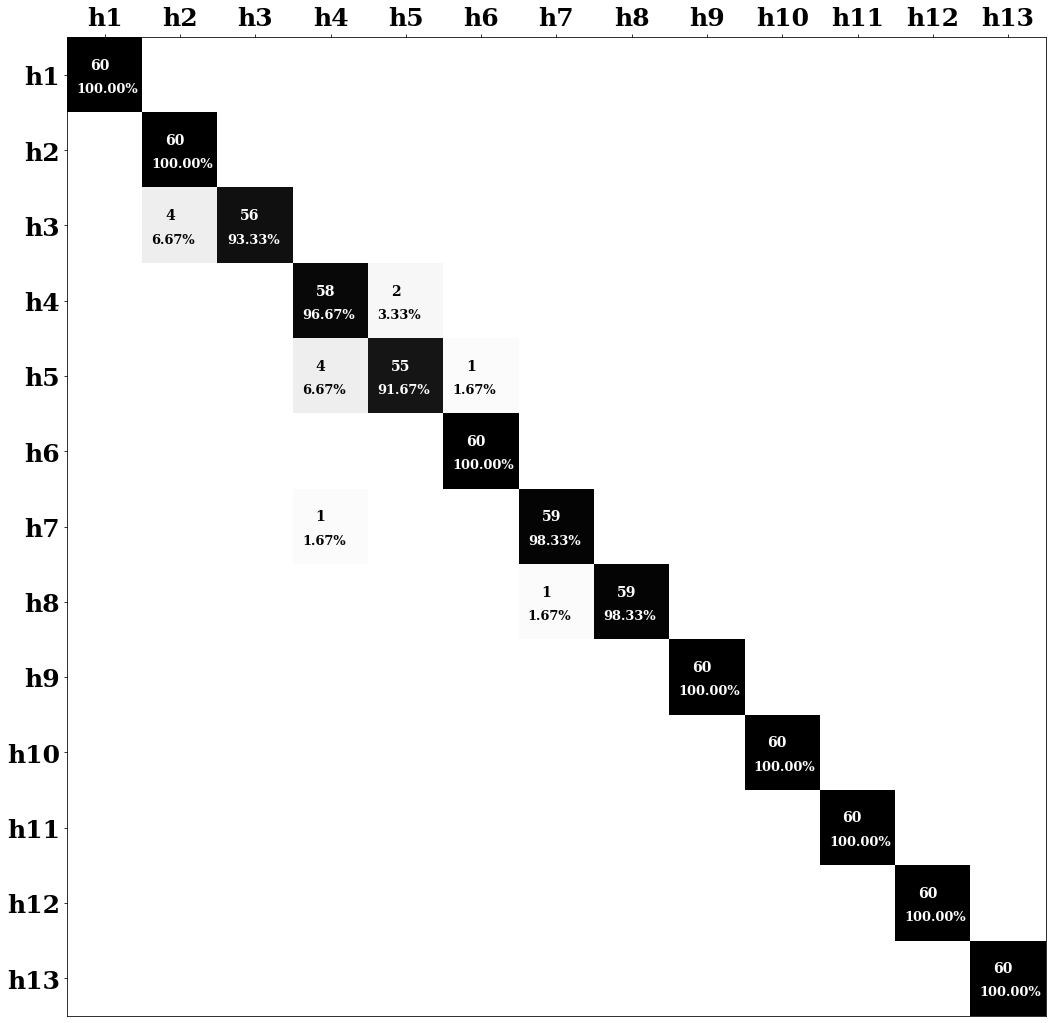

|  2        |  98.33    |  0.9      |  7.116    |
Train on 702 samples, validate on 78 samples
Epoch 1/100
702/702 [==============================] - 6s 8ms/step - loss: 2.4931 - acc: 0.2493 - val_loss: 2.3475 - val_acc: 0.4872
Epoch 2/100
702/702 [==============================] - 1s 1ms/step - loss: 2.3168 - acc: 0.5499 - val_loss: 2.2871 - val_acc: 0.5641
Epoch 3/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2473 - acc: 0.7365 - val_loss: 2.2257 - val_acc: 0.8077
Epoch 4/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2265 - acc: 0.8219 - val_loss: 2.2328 - val_acc: 0.8077
Epoch 5/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2007 - acc: 0.9060 - val_loss: 2.2007 - val_acc: 0.9103
Epoch 6/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1990 - acc: 0.9060 - val_loss: 2.2111 - val_acc: 0.8846
Epoch 7/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1871 - acc: 0.9373 - val_loss:

702/702 [==============================] - 1s 1ms/step - loss: 2.1703 - acc: 0.9929 - val_loss: 2.1755 - val_acc: 0.9615
Epoch 22/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1698 - acc: 0.9943 - val_loss: 2.1811 - val_acc: 0.9359
Epoch 23/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1703 - acc: 0.9943 - val_loss: 2.1744 - val_acc: 0.9359
Epoch 24/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1690 - acc: 0.9986 - val_loss: 2.1768 - val_acc: 0.9615
Epoch 25/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1684 - acc: 0.9957 - val_loss: 2.1749 - val_acc: 0.9359
Epoch 26/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1687 - acc: 0.9943 - val_loss: 2.1773 - val_acc: 0.9615
Epoch 27/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1701 - acc: 0.9886 - val_loss: 2.1832 - val_acc: 0.9487
Epoch 28/100
702/702 [==============================] - 1s 1ms/step - loss:

702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 1.0000 - val_loss: 2.1702 - val_acc: 0.9872
Epoch 43/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 1.0000 - val_loss: 2.1697 - val_acc: 1.0000
Epoch 44/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 1.0000 - val_loss: 2.1694 - val_acc: 1.0000
Epoch 45/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1702 - val_acc: 1.0000
Epoch 46/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 1.0000 - val_loss: 2.1706 - val_acc: 1.0000
Epoch 47/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 0.9986 - val_loss: 2.1699 - val_acc: 1.0000
Epoch 48/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1695 - val_acc: 0.9872
Epoch 49/100
702/702 [==============================] - 1s 1ms/step - loss:

Epoch 2/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2937 - acc: 0.6040 - val_loss: 2.2823 - val_acc: 0.7051
Epoch 3/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2482 - acc: 0.7293 - val_loss: 2.2415 - val_acc: 0.7821
Epoch 4/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2148 - acc: 0.8291 - val_loss: 2.2097 - val_acc: 0.8846
Epoch 5/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2074 - acc: 0.8519 - val_loss: 2.2139 - val_acc: 0.8590
Epoch 6/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1972 - acc: 0.9174 - val_loss: 2.2342 - val_acc: 0.7692
Epoch 7/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1888 - acc: 0.9288 - val_loss: 2.1815 - val_acc: 0.9231
Epoch 8/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1863 - acc: 0.9416 - val_loss: 2.1851 - val_acc: 0.8718
Epoch 9/100
702/702 [==============================] - 1s 1ms/step - 

702/702 [==============================] - 1s 1ms/step - loss: 2.1676 - acc: 1.0000 - val_loss: 2.1737 - val_acc: 0.9744
Epoch 24/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1695 - acc: 0.9929 - val_loss: 2.1745 - val_acc: 0.9744
Epoch 25/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1675 - acc: 0.9986 - val_loss: 2.1737 - val_acc: 0.9744
Epoch 26/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1673 - acc: 0.9986 - val_loss: 2.1746 - val_acc: 0.9615
Epoch 27/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1673 - acc: 1.0000 - val_loss: 2.1730 - val_acc: 0.9744
Epoch 28/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1686 - acc: 0.9972 - val_loss: 2.1736 - val_acc: 0.9872
Epoch 29/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1669 - acc: 1.0000 - val_loss: 2.1734 - val_acc: 0.9872
Epoch 30/100
702/702 [==============================] - 1s 1ms/step - loss:

702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1714 - val_acc: 0.9872
Epoch 45/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 1.0000 - val_loss: 2.1705 - val_acc: 0.9872
Epoch 46/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1713 - val_acc: 0.9615
Epoch 47/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1708 - val_acc: 0.9872
Epoch 48/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1705 - val_acc: 0.9872
Epoch 49/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1707 - val_acc: 0.9872
Epoch 50/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 0.9986 - val_loss: 2.1707 - val_acc: 0.9872
Epoch 51/100
702/702 [==============================] - 1s 1ms/step - loss:

Epoch 4/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2200 - acc: 0.8291 - val_loss: 2.2263 - val_acc: 0.7564
Epoch 5/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2029 - acc: 0.8903 - val_loss: 2.2661 - val_acc: 0.7821
Epoch 6/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2141 - acc: 0.8632 - val_loss: 2.2175 - val_acc: 0.8718
Epoch 7/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1866 - acc: 0.9259 - val_loss: 2.2060 - val_acc: 0.8846
Epoch 8/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1820 - acc: 0.9601 - val_loss: 2.1880 - val_acc: 0.9487
Epoch 9/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1833 - acc: 0.9516 - val_loss: 2.1915 - val_acc: 0.9103
Epoch 10/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1764 - acc: 0.9715 - val_loss: 2.1992 - val_acc: 0.9744
Epoch 11/100
702/702 [==============================] - 1s 1ms/step 

702/702 [==============================] - 1s 1ms/step - loss: 2.1674 - acc: 0.9986 - val_loss: 2.1832 - val_acc: 0.9615
Epoch 26/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1683 - acc: 0.9957 - val_loss: 2.1823 - val_acc: 0.9615
Epoch 27/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1674 - acc: 0.9986 - val_loss: 2.1864 - val_acc: 0.9359
Epoch 28/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1669 - acc: 1.0000 - val_loss: 2.1796 - val_acc: 0.9359
Epoch 29/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1679 - acc: 0.9957 - val_loss: 2.1823 - val_acc: 0.9487
Epoch 30/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1671 - acc: 0.9986 - val_loss: 2.1807 - val_acc: 0.9615
Epoch 31/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1668 - acc: 1.0000 - val_loss: 2.1784 - val_acc: 0.9744
Epoch 32/100
702/702 [==============================] - 1s 1ms/step - loss:

702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1773 - val_acc: 0.9615
Epoch 47/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 0.9986 - val_loss: 2.1775 - val_acc: 0.9615
Epoch 48/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1769 - val_acc: 0.9615
Epoch 49/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1774 - val_acc: 0.9615
Epoch 50/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 1.0000 - val_loss: 2.1778 - val_acc: 0.9615
Epoch 51/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1673 - acc: 0.9986 - val_loss: 2.1789 - val_acc: 0.9615
Epoch 52/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1772 - val_acc: 0.9615
Epoch 53/100
702/702 [==============================] - 1s 1ms/step - loss:

Epoch 6/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1978 - acc: 0.9188 - val_loss: 2.2109 - val_acc: 0.8462
Epoch 7/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1898 - acc: 0.9160 - val_loss: 2.1803 - val_acc: 0.9359
Epoch 8/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1829 - acc: 0.9501 - val_loss: 2.1802 - val_acc: 0.9615
Epoch 9/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1770 - acc: 0.9687 - val_loss: 2.1885 - val_acc: 0.8974
Epoch 10/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1872 - acc: 0.9330 - val_loss: 2.1827 - val_acc: 0.9872
Epoch 11/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1746 - acc: 0.9858 - val_loss: 2.1770 - val_acc: 0.9615
Epoch 12/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1744 - acc: 0.9772 - val_loss: 2.1873 - val_acc: 0.9359
Epoch 13/100
702/702 [==============================] - 1s 1ms/ste

<Figure size 432x288 with 0 Axes>

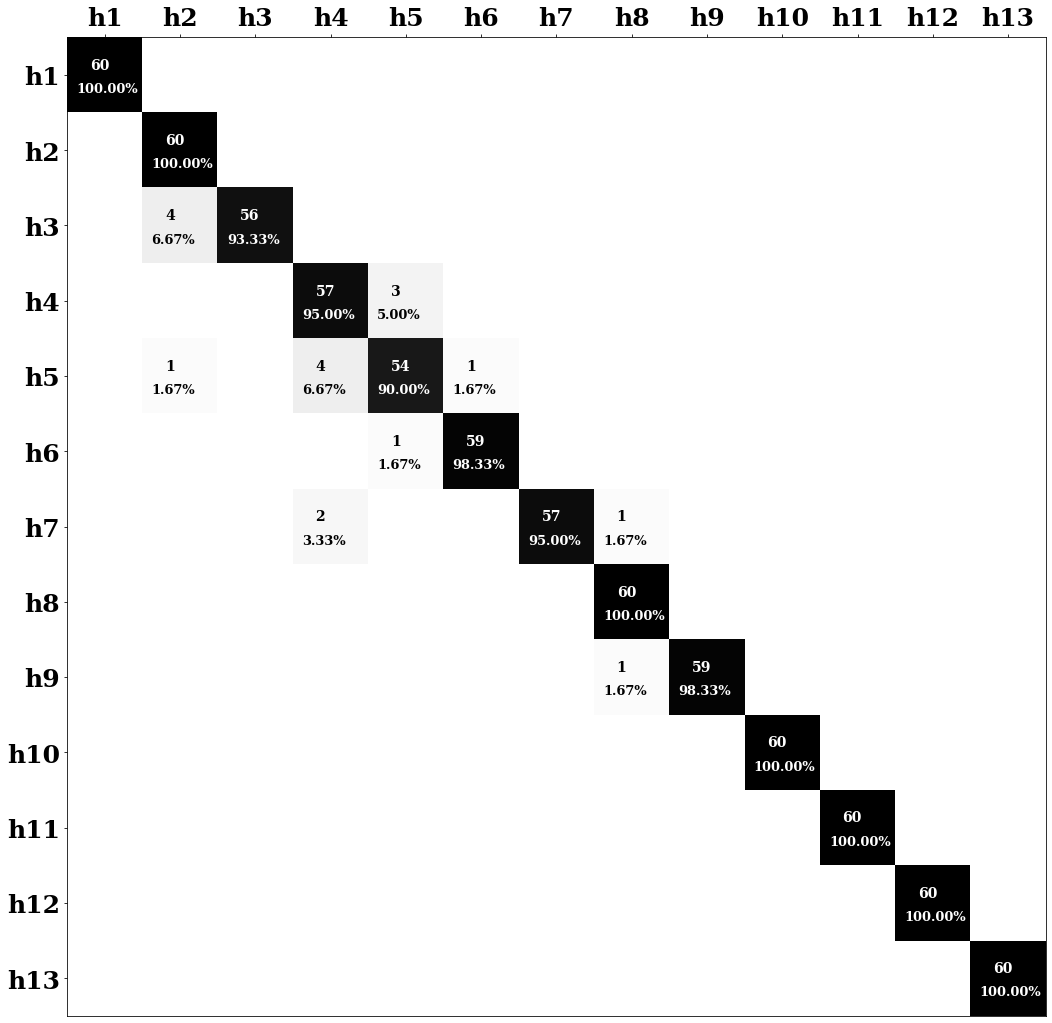

|  3        |  97.69    |  0.9145   |  5.646    |
Train on 702 samples, validate on 78 samples
Epoch 1/100
702/702 [==============================] - 8s 11ms/step - loss: 2.4854 - acc: 0.2892 - val_loss: 2.3731 - val_acc: 0.5256
Epoch 2/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2979 - acc: 0.5840 - val_loss: 2.2600 - val_acc: 0.5897
Epoch 3/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2461 - acc: 0.7194 - val_loss: 2.2558 - val_acc: 0.7564
Epoch 4/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2199 - acc: 0.8305 - val_loss: 2.2069 - val_acc: 0.8333
Epoch 5/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2053 - acc: 0.8789 - val_loss: 2.2667 - val_acc: 0.5897
Epoch 6/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1976 - acc: 0.8946 - val_loss: 2.2358 - val_acc: 0.7692
Epoch 7/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1896 - acc: 0.9274 - val_loss

702/702 [==============================] - 1s 2ms/step - loss: 2.1711 - acc: 0.9900 - val_loss: 2.1952 - val_acc: 0.9231
Epoch 22/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1698 - acc: 0.9915 - val_loss: 2.1771 - val_acc: 0.9744
Epoch 23/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1699 - acc: 0.9943 - val_loss: 2.1737 - val_acc: 0.9872
Epoch 24/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1691 - acc: 0.9957 - val_loss: 2.1720 - val_acc: 0.9872
Epoch 25/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1704 - acc: 0.9943 - val_loss: 2.1775 - val_acc: 0.9744
Epoch 26/100
702/702 [==============================] - 1s 2ms/step - loss: 2.1687 - acc: 0.9943 - val_loss: 2.1784 - val_acc: 0.9744
Epoch 27/100
702/702 [==============================] - 1s 2ms/step - loss: 2.1692 - acc: 0.9972 - val_loss: 2.1846 - val_acc: 0.9487
Epoch 28/100
702/702 [==============================] - 1s 1ms/step - loss:

702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 1.0000 - val_loss: 2.1688 - val_acc: 1.0000
Epoch 43/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1666 - acc: 1.0000 - val_loss: 2.1720 - val_acc: 0.9872
Epoch 44/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 1.0000 - val_loss: 2.1693 - val_acc: 1.0000
Epoch 45/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1714 - val_acc: 1.0000
Epoch 46/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1701 - val_acc: 1.0000
Epoch 47/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1691 - val_acc: 1.0000
Epoch 48/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1732 - val_acc: 1.0000
Epoch 49/100
702/702 [==============================] - 1s 1ms/step - loss:

702/702 [==============================] - 1s 1ms/step - loss: 2.3149 - acc: 0.6111 - val_loss: 2.3180 - val_acc: 0.5769
Epoch 3/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2511 - acc: 0.7521 - val_loss: 2.2753 - val_acc: 0.6795
Epoch 4/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2248 - acc: 0.8105 - val_loss: 2.2257 - val_acc: 0.7436
Epoch 5/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2027 - acc: 0.8989 - val_loss: 2.2328 - val_acc: 0.7179
Epoch 6/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1963 - acc: 0.9088 - val_loss: 2.2013 - val_acc: 0.8077
Epoch 7/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1910 - acc: 0.9501 - val_loss: 2.2102 - val_acc: 0.7821
Epoch 8/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1805 - acc: 0.9587 - val_loss: 2.1805 - val_acc: 0.9103
Epoch 9/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1850

702/702 [==============================] - 3s 5ms/step - loss: 2.1688 - acc: 0.9972 - val_loss: 2.1871 - val_acc: 0.9487
Epoch 24/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1691 - acc: 0.9929 - val_loss: 2.1770 - val_acc: 0.9872
Epoch 25/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1678 - acc: 0.9972 - val_loss: 2.1740 - val_acc: 0.9744
Epoch 26/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1676 - acc: 0.9986 - val_loss: 2.1748 - val_acc: 1.0000
Epoch 27/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1677 - acc: 0.9986 - val_loss: 2.1768 - val_acc: 0.9615
Epoch 28/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1678 - acc: 0.9972 - val_loss: 2.1720 - val_acc: 0.9872
Epoch 29/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1673 - acc: 0.9986 - val_loss: 2.1732 - val_acc: 1.0000
Epoch 30/100
702/702 [==============================] - 1s 1ms/step - loss:

702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 1.0000 - val_loss: 2.1712 - val_acc: 0.9872
Epoch 45/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1708 - val_acc: 0.9872
Epoch 46/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1706 - val_acc: 0.9744
Epoch 47/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1704 - val_acc: 0.9872
Epoch 48/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1704 - val_acc: 0.9744
Epoch 49/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1707 - val_acc: 0.9744
Epoch 50/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1706 - val_acc: 0.9872
Epoch 51/100
702/702 [==============================] - 1s 1ms/step - loss:

Epoch 4/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2307 - acc: 0.7991 - val_loss: 2.2273 - val_acc: 0.8333
Epoch 5/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2064 - acc: 0.8960 - val_loss: 2.2092 - val_acc: 0.8718
Epoch 6/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2000 - acc: 0.8803 - val_loss: 2.2285 - val_acc: 0.7949
Epoch 7/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1891 - acc: 0.9373 - val_loss: 2.1893 - val_acc: 0.8718
Epoch 8/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1874 - acc: 0.9316 - val_loss: 2.1876 - val_acc: 0.8974
Epoch 9/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1807 - acc: 0.9615 - val_loss: 2.2019 - val_acc: 0.7692
Epoch 10/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1776 - acc: 0.9715 - val_loss: 2.1938 - val_acc: 0.9231
Epoch 11/100
702/702 [==============================] - 1s 1ms/step 

702/702 [==============================] - 1s 1ms/step - loss: 2.1678 - acc: 0.9972 - val_loss: 2.1743 - val_acc: 0.9872
Epoch 26/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1679 - acc: 0.9972 - val_loss: 2.1789 - val_acc: 0.9744
Epoch 27/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1681 - acc: 0.9943 - val_loss: 2.1805 - val_acc: 0.9744
Epoch 28/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1675 - acc: 0.9957 - val_loss: 2.1755 - val_acc: 0.9615
Epoch 29/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1673 - acc: 0.9986 - val_loss: 2.1807 - val_acc: 0.9744
Epoch 30/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1674 - acc: 0.9972 - val_loss: 2.1807 - val_acc: 0.9744
Epoch 31/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1671 - acc: 0.9972 - val_loss: 2.1807 - val_acc: 0.9615
Epoch 32/100
702/702 [==============================] - 1s 1ms/step - loss:

Epoch 46/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1789 - val_acc: 0.9744
Epoch 47/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1788 - val_acc: 0.9744
Epoch 48/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1791 - val_acc: 0.9744
Epoch 49/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1791 - val_acc: 0.9744
Epoch 50/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1789 - val_acc: 0.9744
Epoch 51/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1789 - val_acc: 0.9744
Epoch 52/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1787 - val_acc: 0.9744
Epoch 53/100
702/702 [==============================] - 1s 1ms

Epoch 6/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2024 - acc: 0.9003 - val_loss: 2.2809 - val_acc: 0.7949
Epoch 7/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1914 - acc: 0.9373 - val_loss: 2.2147 - val_acc: 0.9231
Epoch 8/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1957 - acc: 0.9160 - val_loss: 2.1871 - val_acc: 0.8974
Epoch 9/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1822 - acc: 0.9615 - val_loss: 2.2079 - val_acc: 0.8590
Epoch 10/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1782 - acc: 0.9829 - val_loss: 2.1795 - val_acc: 0.9487
Epoch 11/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1817 - acc: 0.9687 - val_loss: 2.1826 - val_acc: 0.8846
Epoch 12/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1771 - acc: 0.9729 - val_loss: 2.1800 - val_acc: 0.9487
Epoch 13/100
702/702 [==============================] - 1s 1ms/ste

<Figure size 432x288 with 0 Axes>

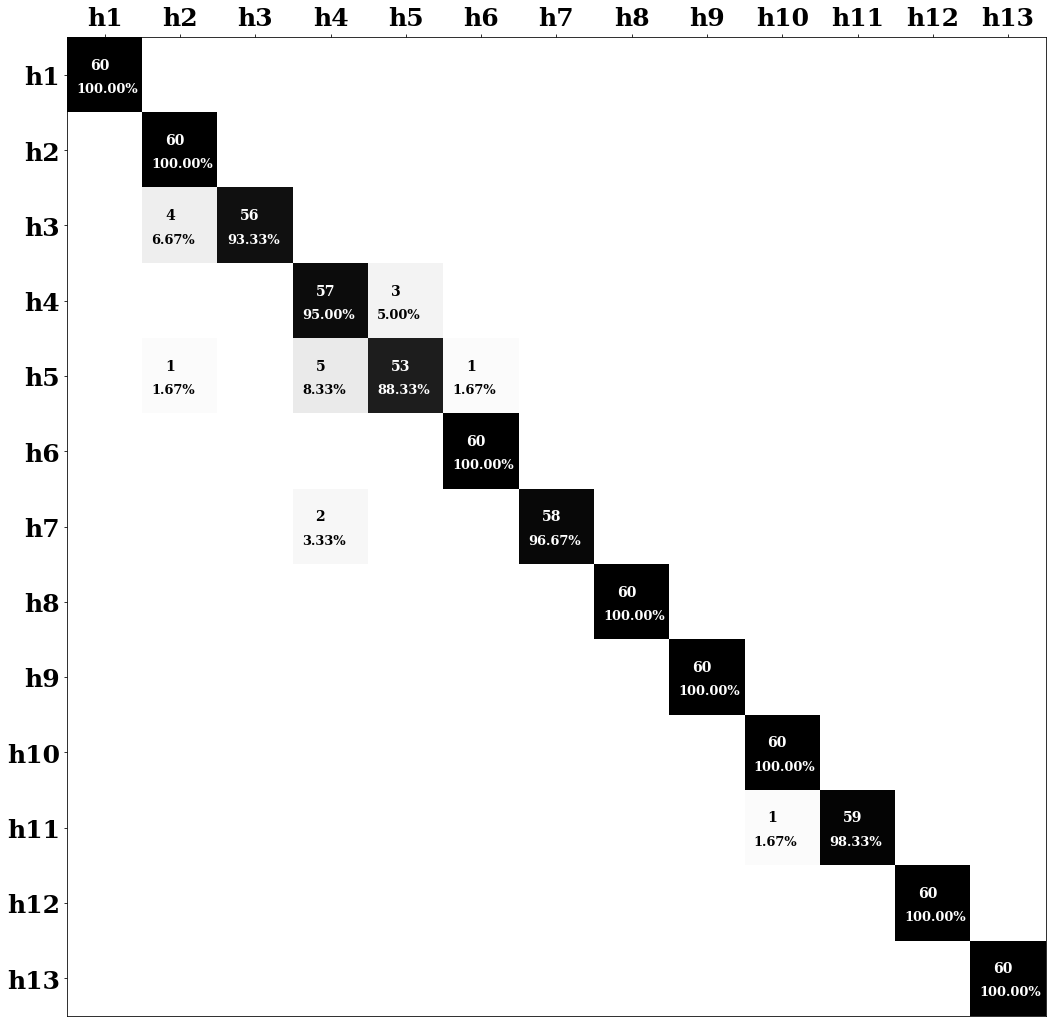

|  4        |  97.82    |  0.9184   |  7.419    |
Train on 702 samples, validate on 78 samples
Epoch 1/100
702/702 [==============================] - 10s 14ms/step - loss: 2.4902 - acc: 0.2949 - val_loss: 2.5180 - val_acc: 0.2564
Epoch 2/100
702/702 [==============================] - 1s 1ms/step - loss: 2.3067 - acc: 0.5698 - val_loss: 2.2972 - val_acc: 0.5769
Epoch 3/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2453 - acc: 0.7336 - val_loss: 2.2551 - val_acc: 0.7436
Epoch 4/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2267 - acc: 0.8348 - val_loss: 2.2183 - val_acc: 0.8205
Epoch 5/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2131 - acc: 0.8632 - val_loss: 2.2035 - val_acc: 0.8462
Epoch 6/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1990 - acc: 0.9031 - val_loss: 2.2032 - val_acc: 0.7821
Epoch 7/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1874 - acc: 0.9402 - val_los

Epoch 21/100
702/702 [==============================] - 4s 5ms/step - loss: 2.1694 - acc: 0.9972 - val_loss: 2.1717 - val_acc: 0.9744
Epoch 22/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1679 - acc: 0.9986 - val_loss: 2.1702 - val_acc: 0.9744
Epoch 23/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1687 - acc: 0.9972 - val_loss: 2.1704 - val_acc: 1.0000
Epoch 24/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1679 - acc: 0.9986 - val_loss: 2.1709 - val_acc: 1.0000
Epoch 25/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1677 - acc: 0.9986 - val_loss: 2.1712 - val_acc: 0.9872
Epoch 26/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1674 - acc: 0.9972 - val_loss: 2.1708 - val_acc: 0.9872
Epoch 27/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1672 - acc: 0.9986 - val_loss: 2.1739 - val_acc: 0.9744
Epoch 28/100
702/702 [==============================] - 1s 1ms

702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1705 - val_acc: 1.0000
Epoch 43/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1715 - val_acc: 1.0000
Epoch 44/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1666 - acc: 1.0000 - val_loss: 2.1711 - val_acc: 1.0000
Epoch 45/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1689 - val_acc: 1.0000
Epoch 46/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1686 - val_acc: 1.0000
Epoch 47/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1693 - val_acc: 1.0000
Epoch 48/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1696 - val_acc: 1.0000
Epoch 49/100
702/702 [==============================] - 1s 1ms/step - loss:

702/702 [==============================] - 1s 1ms/step - loss: 2.3154 - acc: 0.5456 - val_loss: 2.2714 - val_acc: 0.7051
Epoch 3/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2532 - acc: 0.7422 - val_loss: 2.2325 - val_acc: 0.8718
Epoch 4/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2265 - acc: 0.8405 - val_loss: 2.2488 - val_acc: 0.7692
Epoch 5/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2091 - acc: 0.8618 - val_loss: 2.1978 - val_acc: 0.8205
Epoch 6/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1974 - acc: 0.9031 - val_loss: 2.2153 - val_acc: 0.8718
Epoch 7/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1951 - acc: 0.9031 - val_loss: 2.2728 - val_acc: 0.7949
Epoch 8/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1891 - acc: 0.9345 - val_loss: 2.1851 - val_acc: 0.9103
Epoch 9/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1830

Epoch 23/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1684 - acc: 0.9972 - val_loss: 2.1716 - val_acc: 0.9744
Epoch 24/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1703 - acc: 0.9915 - val_loss: 2.1848 - val_acc: 0.9615
Epoch 25/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1684 - acc: 0.9943 - val_loss: 2.1713 - val_acc: 1.0000
Epoch 26/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1689 - acc: 0.9972 - val_loss: 2.1764 - val_acc: 0.9744
Epoch 27/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1689 - acc: 0.9886 - val_loss: 2.1799 - val_acc: 0.9359
Epoch 28/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1702 - acc: 0.9843 - val_loss: 2.1700 - val_acc: 1.0000
Epoch 29/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1680 - acc: 0.9929 - val_loss: 2.1826 - val_acc: 0.9615
Epoch 30/100
702/702 [==============================] - 1s 1ms

702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 1.0000 - val_loss: 2.1701 - val_acc: 1.0000
Epoch 45/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1670 - acc: 0.9972 - val_loss: 2.1702 - val_acc: 0.9872
Epoch 46/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1706 - val_acc: 0.9872
Epoch 47/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1704 - val_acc: 0.9872
Epoch 48/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1710 - val_acc: 0.9872
Epoch 49/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1702 - val_acc: 0.9872
Epoch 50/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1701 - val_acc: 0.9872
Epoch 51/100
702/702 [==============================] - 1s 1ms/step - loss:

Epoch 4/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2203 - acc: 0.8177 - val_loss: 2.2207 - val_acc: 0.7821
Epoch 5/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2043 - acc: 0.8960 - val_loss: 2.2462 - val_acc: 0.7308
Epoch 6/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1987 - acc: 0.9017 - val_loss: 2.2645 - val_acc: 0.8077
Epoch 7/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1874 - acc: 0.9359 - val_loss: 2.1881 - val_acc: 0.8718
Epoch 8/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1867 - acc: 0.9544 - val_loss: 2.1828 - val_acc: 0.9744
Epoch 9/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1825 - acc: 0.9544 - val_loss: 2.1891 - val_acc: 0.9487
Epoch 10/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1770 - acc: 0.9772 - val_loss: 2.1824 - val_acc: 0.9744
Epoch 11/100
702/702 [==============================] - 1s 1ms/step 

702/702 [==============================] - 1s 1ms/step - loss: 2.1686 - acc: 0.9986 - val_loss: 2.1835 - val_acc: 0.9487
Epoch 26/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1680 - acc: 0.9972 - val_loss: 2.1788 - val_acc: 0.9872
Epoch 27/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1690 - acc: 0.9900 - val_loss: 2.1844 - val_acc: 0.9103
Epoch 28/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1685 - acc: 0.9943 - val_loss: 2.1769 - val_acc: 0.9744
Epoch 29/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1678 - acc: 0.9986 - val_loss: 2.2112 - val_acc: 0.8590
Epoch 30/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1680 - acc: 0.9943 - val_loss: 2.1775 - val_acc: 0.9744
Epoch 31/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1685 - acc: 0.9986 - val_loss: 2.1883 - val_acc: 0.9487
Epoch 32/100
702/702 [==============================] - 1s 1ms/step - loss:

702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1783 - val_acc: 0.9744
Epoch 47/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1777 - val_acc: 0.9744
Epoch 48/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1780 - val_acc: 0.9744
Epoch 49/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1776 - val_acc: 0.9744
Epoch 50/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1776 - val_acc: 0.9744
Epoch 51/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1776 - val_acc: 0.9744
Epoch 52/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1776 - val_acc: 0.9744
Epoch 53/100
702/702 [==============================] - 1s 1ms/step - loss:

Epoch 6/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2038 - acc: 0.8746 - val_loss: 2.1979 - val_acc: 0.9103
Epoch 7/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1851 - acc: 0.9516 - val_loss: 2.1930 - val_acc: 0.9231
Epoch 8/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1887 - acc: 0.9416 - val_loss: 2.1783 - val_acc: 0.9744
Epoch 9/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1871 - acc: 0.9302 - val_loss: 2.1923 - val_acc: 0.8718
Epoch 10/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1783 - acc: 0.9615 - val_loss: 2.1748 - val_acc: 0.9744
Epoch 11/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1765 - acc: 0.9772 - val_loss: 2.1773 - val_acc: 0.9872
Epoch 12/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1824 - acc: 0.9601 - val_loss: 2.1764 - val_acc: 0.9487
Epoch 13/100
702/702 [==============================] - 1s 1ms/ste

<Figure size 432x288 with 0 Axes>

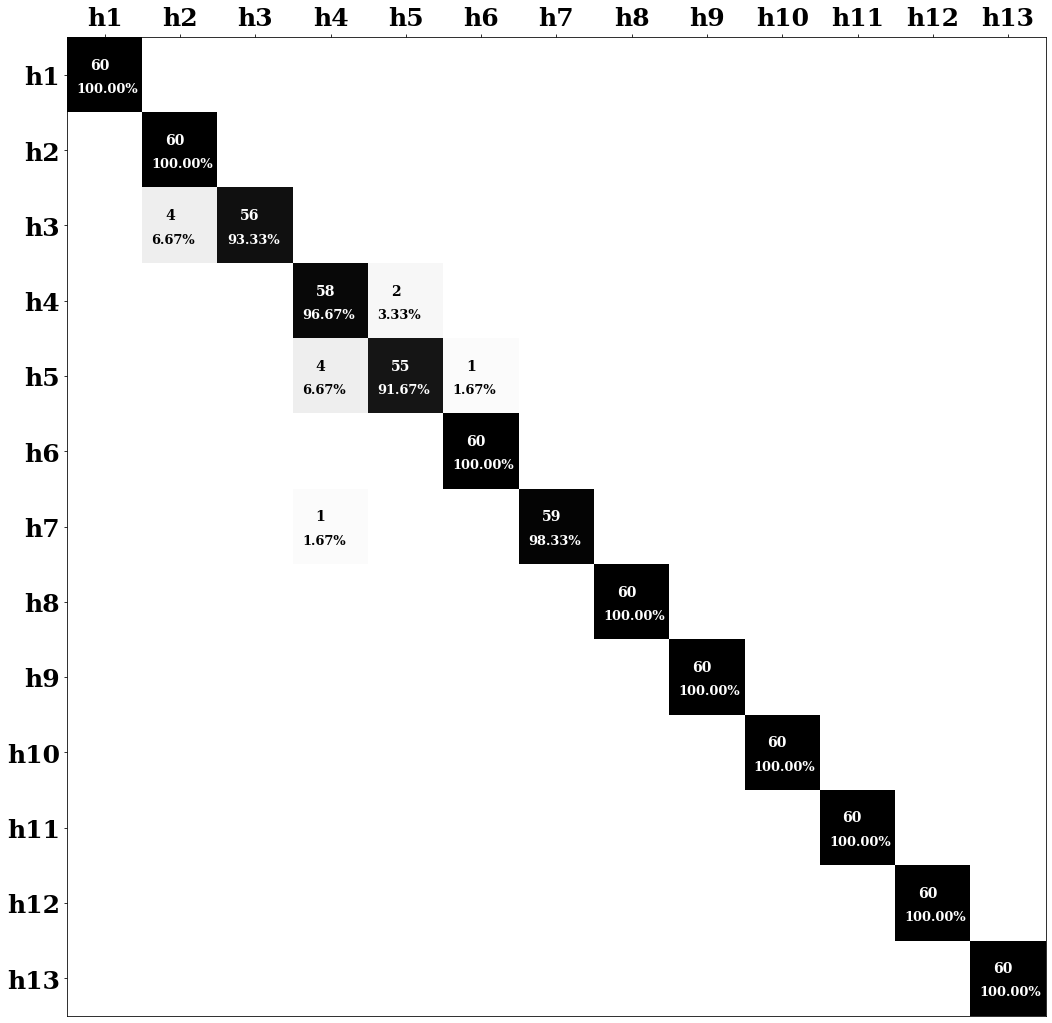

|  5        |  98.46    |  0.9108   |  7.582    |
Train on 702 samples, validate on 78 samples
Epoch 1/100
702/702 [==============================] - 12s 18ms/step - loss: 2.5173 - acc: 0.2350 - val_loss: 2.3444 - val_acc: 0.5128
Epoch 2/100
702/702 [==============================] - 1s 1ms/step - loss: 2.3024 - acc: 0.5769 - val_loss: 2.2559 - val_acc: 0.6282
Epoch 3/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2426 - acc: 0.7450 - val_loss: 2.2709 - val_acc: 0.6282
Epoch 4/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2215 - acc: 0.8376 - val_loss: 2.2100 - val_acc: 0.8718
Epoch 5/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2073 - acc: 0.8590 - val_loss: 2.1978 - val_acc: 0.8590
Epoch 6/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1915 - acc: 0.9188 - val_loss: 2.2555 - val_acc: 0.8462
Epoch 7/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1913 - acc: 0.9217 - val_los

702/702 [==============================] - 1s 1ms/step - loss: 2.1709 - acc: 0.9872 - val_loss: 2.1718 - val_acc: 0.9744
Epoch 22/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1717 - acc: 0.9929 - val_loss: 2.1709 - val_acc: 0.9744
Epoch 23/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1687 - acc: 0.9915 - val_loss: 2.1740 - val_acc: 0.9359
Epoch 24/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1686 - acc: 0.9957 - val_loss: 2.1742 - val_acc: 0.9487
Epoch 25/100
702/702 [==============================] - 5s 6ms/step - loss: 2.1729 - acc: 0.9729 - val_loss: 2.1711 - val_acc: 0.9744
Epoch 26/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1678 - acc: 0.9986 - val_loss: 2.1740 - val_acc: 0.9744
Epoch 27/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1681 - acc: 0.9972 - val_loss: 2.1709 - val_acc: 0.9744
Epoch 28/100
702/702 [==============================] - 1s 1ms/step - loss:

702/702 [==============================] - 1s 1ms/step - loss: 2.1666 - acc: 1.0000 - val_loss: 2.1732 - val_acc: 1.0000
Epoch 43/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1666 - acc: 1.0000 - val_loss: 2.1789 - val_acc: 0.9615
Epoch 44/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1673 - acc: 0.9986 - val_loss: 2.1699 - val_acc: 0.9872
Epoch 45/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 1.0000 - val_loss: 2.1693 - val_acc: 0.9872
Epoch 46/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 1.0000 - val_loss: 2.1709 - val_acc: 0.9872
Epoch 47/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 1.0000 - val_loss: 2.1719 - val_acc: 0.9744
Epoch 48/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1670 - acc: 0.9986 - val_loss: 2.1713 - val_acc: 0.9872
Epoch 49/100
702/702 [==============================] - 1s 1ms/step - loss:

702/702 [==============================] - 1s 1ms/step - loss: 2.3360 - acc: 0.5399 - val_loss: 2.2818 - val_acc: 0.6538
Epoch 3/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2537 - acc: 0.7151 - val_loss: 2.2691 - val_acc: 0.7051
Epoch 4/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2225 - acc: 0.8177 - val_loss: 2.2455 - val_acc: 0.7436
Epoch 5/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2102 - acc: 0.8746 - val_loss: 2.2006 - val_acc: 0.8846
Epoch 6/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2039 - acc: 0.8946 - val_loss: 2.2010 - val_acc: 0.8077
Epoch 7/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1866 - acc: 0.9459 - val_loss: 2.1962 - val_acc: 0.8718
Epoch 8/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1914 - acc: 0.9373 - val_loss: 2.1796 - val_acc: 0.9744
Epoch 9/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1781

702/702 [==============================] - 1s 1ms/step - loss: 2.1707 - acc: 0.9972 - val_loss: 2.1762 - val_acc: 1.0000
Epoch 24/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1696 - acc: 0.9943 - val_loss: 2.1743 - val_acc: 0.9744
Epoch 25/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1685 - acc: 0.9986 - val_loss: 2.1728 - val_acc: 0.9744
Epoch 26/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1683 - acc: 0.9929 - val_loss: 2.1761 - val_acc: 0.9744
Epoch 27/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1716 - acc: 0.9943 - val_loss: 2.1815 - val_acc: 0.9615
Epoch 28/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1680 - acc: 1.0000 - val_loss: 2.1727 - val_acc: 0.9872
Epoch 29/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1701 - acc: 0.9929 - val_loss: 2.1768 - val_acc: 0.9615
Epoch 30/100
702/702 [==============================] - 1s 1ms/step - loss:

Epoch 44/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 1.0000 - val_loss: 2.1707 - val_acc: 0.9872
Epoch 45/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1695 - val_acc: 0.9744
Epoch 46/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1703 - val_acc: 0.9744
Epoch 47/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1712 - val_acc: 0.9744
Epoch 48/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1702 - val_acc: 0.9744
Epoch 49/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1695 - val_acc: 0.9744
Epoch 50/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1697 - val_acc: 0.9744
Epoch 51/100
702/702 [==============================] - 1s 1ms

Epoch 4/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2349 - acc: 0.8063 - val_loss: 2.2176 - val_acc: 0.8205
Epoch 5/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2028 - acc: 0.8846 - val_loss: 2.2189 - val_acc: 0.8077
Epoch 6/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1961 - acc: 0.9231 - val_loss: 2.2002 - val_acc: 0.9231
Epoch 7/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1967 - acc: 0.9088 - val_loss: 2.1869 - val_acc: 0.9487
Epoch 8/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1817 - acc: 0.9601 - val_loss: 2.2124 - val_acc: 0.8974
Epoch 9/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1841 - acc: 0.9501 - val_loss: 2.1941 - val_acc: 0.9231
Epoch 10/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1840 - acc: 0.9544 - val_loss: 2.1915 - val_acc: 0.9487
Epoch 11/100
702/702 [==============================] - 1s 1ms/step 

Epoch 25/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1675 - acc: 0.9986 - val_loss: 2.1871 - val_acc: 0.9615
Epoch 26/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1684 - acc: 0.9972 - val_loss: 2.1800 - val_acc: 0.9615
Epoch 27/100
702/702 [==============================] - 1s 2ms/step - loss: 2.1675 - acc: 0.9972 - val_loss: 2.1941 - val_acc: 0.9103
Epoch 28/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1682 - acc: 0.9972 - val_loss: 2.1797 - val_acc: 0.9487
Epoch 29/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1676 - acc: 0.9986 - val_loss: 2.1860 - val_acc: 0.9231
Epoch 30/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1672 - acc: 0.9972 - val_loss: 2.1850 - val_acc: 0.9231
Epoch 31/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1670 - acc: 1.0000 - val_loss: 2.1856 - val_acc: 0.9487
Epoch 32/100
702/702 [==============================] - 1s 1ms

702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 1.0000 - val_loss: 2.1781 - val_acc: 0.9744
Epoch 47/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 1.0000 - val_loss: 2.1779 - val_acc: 0.9744
Epoch 48/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 1.0000 - val_loss: 2.1772 - val_acc: 0.9744
Epoch 49/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1778 - val_acc: 0.9744
Epoch 50/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1778 - val_acc: 0.9744
Epoch 51/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1778 - val_acc: 0.9744
Epoch 52/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1775 - val_acc: 0.9744
Epoch 53/100
702/702 [==============================] - 1s 1ms/step - loss:

Epoch 6/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1909 - acc: 0.9231 - val_loss: 2.2480 - val_acc: 0.7436
Epoch 7/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1882 - acc: 0.9359 - val_loss: 2.1809 - val_acc: 0.9359
Epoch 8/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1816 - acc: 0.9672 - val_loss: 2.2101 - val_acc: 0.8462
Epoch 9/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1843 - acc: 0.9530 - val_loss: 2.1888 - val_acc: 0.9487
Epoch 10/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1759 - acc: 0.9744 - val_loss: 2.1784 - val_acc: 0.9359
Epoch 11/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1798 - acc: 0.9615 - val_loss: 2.1783 - val_acc: 0.9615
Epoch 12/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1741 - acc: 0.9843 - val_loss: 2.1800 - val_acc: 0.9487
Epoch 13/100
702/702 [==============================] - 1s 1ms/ste

<Figure size 432x288 with 0 Axes>

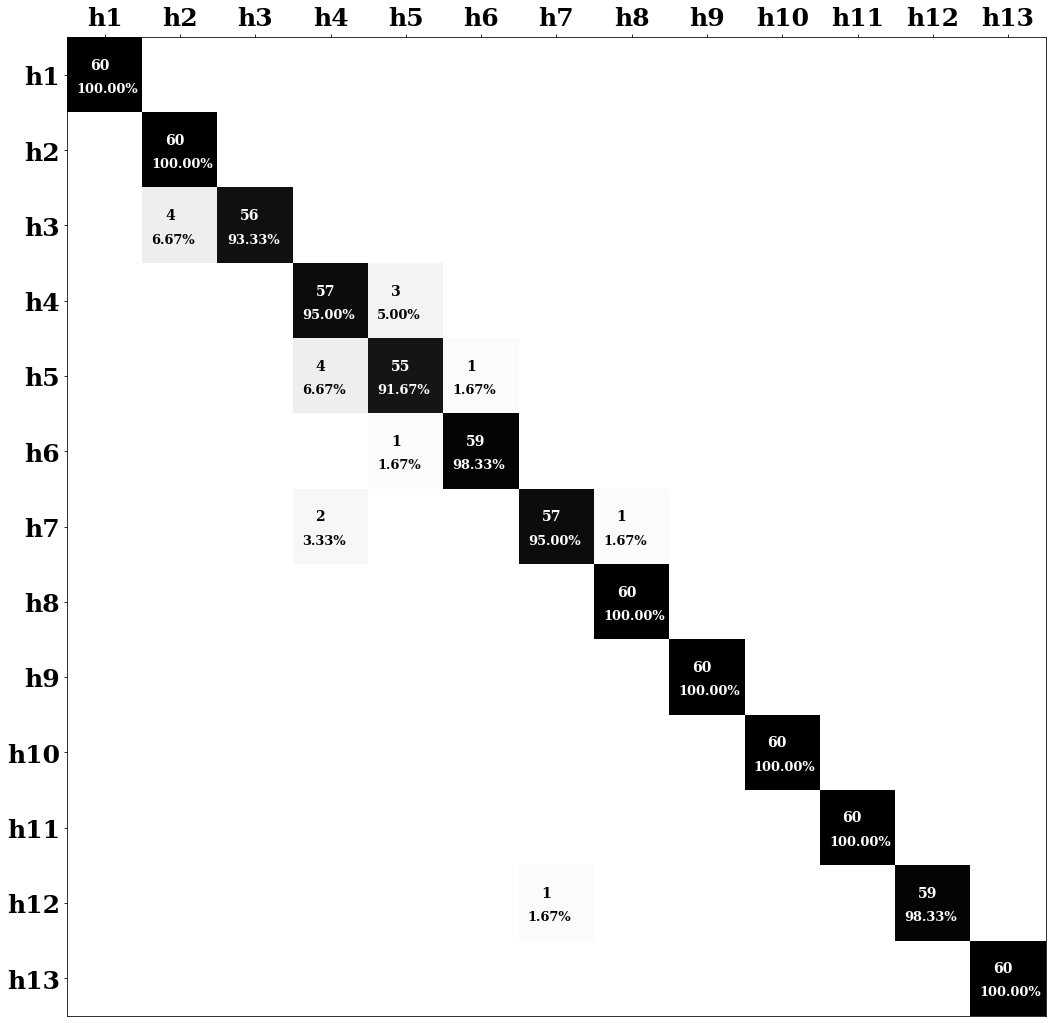

|  6        |  97.82    |  0.9822   |  9.621    |
Train on 702 samples, validate on 78 samples
Epoch 1/100
702/702 [==============================] - 15s 22ms/step - loss: 2.5094 - acc: 0.2934 - val_loss: 2.3234 - val_acc: 0.5385
Epoch 2/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2988 - acc: 0.5997 - val_loss: 2.3254 - val_acc: 0.4487
Epoch 3/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2436 - acc: 0.7450 - val_loss: 2.2863 - val_acc: 0.6667
Epoch 4/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2226 - acc: 0.8405 - val_loss: 2.2655 - val_acc: 0.7308
Epoch 5/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1993 - acc: 0.9145 - val_loss: 2.2136 - val_acc: 0.8718
Epoch 6/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1980 - acc: 0.9074 - val_loss: 2.1932 - val_acc: 0.8718
Epoch 7/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1910 - acc: 0.9359 - val_los

Epoch 21/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1715 - acc: 0.9915 - val_loss: 2.1784 - val_acc: 0.9615
Epoch 22/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1703 - acc: 0.9929 - val_loss: 2.1873 - val_acc: 0.9615
Epoch 23/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1696 - acc: 0.9886 - val_loss: 2.1748 - val_acc: 0.9744
Epoch 24/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1701 - acc: 0.9872 - val_loss: 2.1829 - val_acc: 0.9359
Epoch 25/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1693 - acc: 0.9929 - val_loss: 2.1770 - val_acc: 0.9231
Epoch 26/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1699 - acc: 0.9900 - val_loss: 2.1817 - val_acc: 0.9359
Epoch 27/100
702/702 [==============================] - 5s 8ms/step - loss: 2.1710 - acc: 0.9943 - val_loss: 2.1739 - val_acc: 0.9615
Epoch 28/100
702/702 [==============================] - 1s 1ms

Epoch 42/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1671 - acc: 0.9986 - val_loss: 2.1850 - val_acc: 0.9744
Epoch 43/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1669 - acc: 0.9972 - val_loss: 2.1865 - val_acc: 1.0000
Epoch 44/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1666 - acc: 1.0000 - val_loss: 2.1837 - val_acc: 1.0000
Epoch 45/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 1.0000 - val_loss: 2.1842 - val_acc: 0.9872
Epoch 46/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1675 - acc: 1.0000 - val_loss: 2.1783 - val_acc: 1.0000
Epoch 47/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 1.0000 - val_loss: 2.1836 - val_acc: 0.9872
Epoch 48/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1667 - acc: 0.9986 - val_loss: 2.1815 - val_acc: 0.9872
Epoch 49/100
702/702 [==============================] - 1s 1ms

Epoch 2/100
702/702 [==============================] - 1s 1ms/step - loss: 2.3146 - acc: 0.5712 - val_loss: 2.3181 - val_acc: 0.6667
Epoch 3/100
702/702 [==============================] - 1s 2ms/step - loss: 2.2478 - acc: 0.7536 - val_loss: 2.2312 - val_acc: 0.7692
Epoch 4/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2155 - acc: 0.8248 - val_loss: 2.2331 - val_acc: 0.7692
Epoch 5/100
702/702 [==============================] - 1s 2ms/step - loss: 2.2065 - acc: 0.8789 - val_loss: 2.1933 - val_acc: 0.9487
Epoch 6/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1947 - acc: 0.9160 - val_loss: 2.1917 - val_acc: 0.9231
Epoch 7/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1895 - acc: 0.9373 - val_loss: 2.2231 - val_acc: 0.8205
Epoch 8/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1870 - acc: 0.9573 - val_loss: 2.1776 - val_acc: 1.0000
Epoch 9/100
702/702 [==============================] - 1s 1ms/step - 

702/702 [==============================] - 1s 2ms/step - loss: 2.1705 - acc: 0.9929 - val_loss: 2.1707 - val_acc: 1.0000
Epoch 24/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1694 - acc: 0.9943 - val_loss: 2.1717 - val_acc: 0.9872
Epoch 25/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1688 - acc: 0.9957 - val_loss: 2.1743 - val_acc: 0.9615
Epoch 26/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1712 - acc: 0.9900 - val_loss: 2.1716 - val_acc: 0.9872
Epoch 27/100
702/702 [==============================] - ETA: 0s - loss: 2.1676 - acc: 0.998 - 1s 1ms/step - loss: 2.1676 - acc: 0.9986 - val_loss: 2.1729 - val_acc: 0.9872
Epoch 28/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1680 - acc: 0.9972 - val_loss: 2.1771 - val_acc: 0.9359
Epoch 29/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1681 - acc: 0.9957 - val_loss: 2.1872 - val_acc: 0.8974
Epoch 30/100
702/702 [===============

Epoch 84/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1662 - acc: 1.0000 - val_loss: 2.1685 - val_acc: 1.0000
Epoch 85/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1662 - acc: 1.0000 - val_loss: 2.1685 - val_acc: 1.0000
Epoch 86/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1662 - acc: 1.0000 - val_loss: 2.1684 - val_acc: 1.0000
Epoch 87/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1662 - acc: 1.0000 - val_loss: 2.1683 - val_acc: 1.0000
Epoch 88/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1662 - acc: 1.0000 - val_loss: 2.1686 - val_acc: 1.0000
Epoch 89/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1662 - acc: 1.0000 - val_loss: 2.1682 - val_acc: 1.0000
Epoch 90/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1662 - acc: 1.0000 - val_loss: 2.1682 - val_acc: 1.0000
Epoch 91/100
702/702 [==============================] - 1s 1ms

Epoch 44/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 0.9986 - val_loss: 2.1726 - val_acc: 0.9872
Epoch 45/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1720 - val_acc: 0.9872
Epoch 46/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1667 - acc: 1.0000 - val_loss: 2.1706 - val_acc: 0.9872
Epoch 47/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1714 - val_acc: 0.9872
Epoch 48/100
702/702 [==============================] - 1s 2ms/step - loss: 2.1665 - acc: 1.0000 - val_loss: 2.1725 - val_acc: 0.9872
Epoch 49/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1741 - val_acc: 0.9872
Epoch 50/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1667 - acc: 0.9957 - val_loss: 2.1717 - val_acc: 0.9872
Epoch 51/100
702/702 [==============================] - 1s 1ms

Epoch 4/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2151 - acc: 0.8462 - val_loss: 2.2367 - val_acc: 0.7564
Epoch 5/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2096 - acc: 0.8618 - val_loss: 2.2178 - val_acc: 0.7821
Epoch 6/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1924 - acc: 0.9231 - val_loss: 2.1988 - val_acc: 0.8205
Epoch 7/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1861 - acc: 0.9459 - val_loss: 2.1940 - val_acc: 0.8846
Epoch 8/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1843 - acc: 0.9459 - val_loss: 2.1818 - val_acc: 0.9359
Epoch 9/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1789 - acc: 0.9615 - val_loss: 2.1929 - val_acc: 0.8974
Epoch 10/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1762 - acc: 0.9786 - val_loss: 2.1930 - val_acc: 0.9744
Epoch 11/100
702/702 [==============================] - 1s 1ms/step 

Epoch 25/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1683 - acc: 0.9957 - val_loss: 2.1819 - val_acc: 0.9487
Epoch 26/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1707 - acc: 0.9886 - val_loss: 2.1832 - val_acc: 0.9487
Epoch 27/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1680 - acc: 0.9972 - val_loss: 2.1790 - val_acc: 0.9744
Epoch 28/100
702/702 [==============================] - 6s 8ms/step - loss: 2.1678 - acc: 0.9972 - val_loss: 2.1994 - val_acc: 0.8974
Epoch 29/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1682 - acc: 0.9972 - val_loss: 2.1761 - val_acc: 0.9744
Epoch 30/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1678 - acc: 0.9972 - val_loss: 2.1861 - val_acc: 0.9487
Epoch 31/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1675 - acc: 0.9957 - val_loss: 2.1798 - val_acc: 0.9744
Epoch 32/100
702/702 [==============================] - 1s 1ms

702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1773 - val_acc: 0.9744
Epoch 47/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1669 - acc: 0.9972 - val_loss: 2.1769 - val_acc: 0.9744
Epoch 48/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1770 - val_acc: 0.9744
Epoch 49/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1770 - val_acc: 0.9744
Epoch 50/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1772 - val_acc: 0.9744
Epoch 51/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1775 - val_acc: 0.9744
Epoch 52/100
702/702 [==============================] - 1s 2ms/step - loss: 2.1666 - acc: 1.0000 - val_loss: 2.1771 - val_acc: 0.9744
Epoch 53/100
702/702 [==============================] - 1s 1ms/step - loss:

Epoch 6/100
702/702 [==============================] - 1s 2ms/step - loss: 2.1926 - acc: 0.9160 - val_loss: 2.1931 - val_acc: 0.8974
Epoch 7/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1923 - acc: 0.9145 - val_loss: 2.2046 - val_acc: 0.9231
Epoch 8/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1840 - acc: 0.9459 - val_loss: 2.2123 - val_acc: 0.8462
Epoch 9/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1824 - acc: 0.9558 - val_loss: 2.1855 - val_acc: 0.9487
Epoch 10/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1806 - acc: 0.9573 - val_loss: 2.1844 - val_acc: 0.9359
Epoch 11/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1768 - acc: 0.9715 - val_loss: 2.1817 - val_acc: 0.9359
Epoch 12/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1750 - acc: 0.9786 - val_loss: 2.1823 - val_acc: 0.9103
Epoch 13/100
702/702 [==============================] - 1s 1ms/ste

<Figure size 432x288 with 0 Axes>

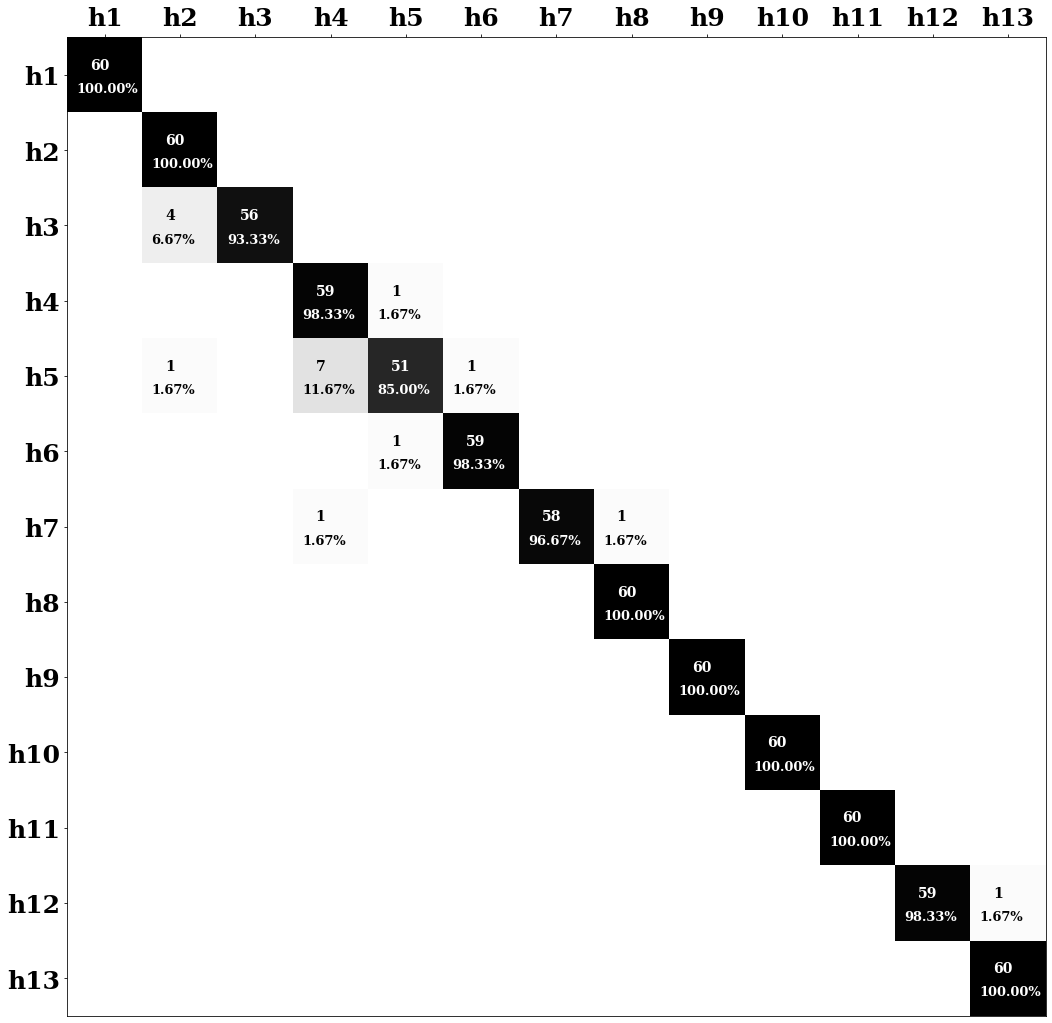

|  7        |  97.69    |  0.9148   |  9.402    |
Train on 702 samples, validate on 78 samples
Epoch 1/100
702/702 [==============================] - 18s 25ms/step - loss: 2.4868 - acc: 0.2821 - val_loss: 2.4245 - val_acc: 0.3718
Epoch 2/100
702/702 [==============================] - 1s 1ms/step - loss: 2.3068 - acc: 0.5541 - val_loss: 2.3164 - val_acc: 0.5385
Epoch 3/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2453 - acc: 0.7322 - val_loss: 2.2411 - val_acc: 0.7308
Epoch 4/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2226 - acc: 0.8205 - val_loss: 2.2677 - val_acc: 0.6538
Epoch 5/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2168 - acc: 0.8419 - val_loss: 2.2061 - val_acc: 0.8718
Epoch 6/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1891 - acc: 0.9245 - val_loss: 2.3131 - val_acc: 0.6026
Epoch 7/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1983 - acc: 0.8832 - val_los

702/702 [==============================] - 1s 1ms/step - loss: 2.1699 - acc: 0.9929 - val_loss: 2.1741 - val_acc: 0.9744
Epoch 22/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1720 - acc: 0.9886 - val_loss: 2.1750 - val_acc: 0.9487
Epoch 23/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1685 - acc: 0.9972 - val_loss: 2.2218 - val_acc: 0.8974
Epoch 24/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1731 - acc: 0.9872 - val_loss: 2.1835 - val_acc: 0.9359
Epoch 25/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1695 - acc: 0.9943 - val_loss: 2.1783 - val_acc: 0.8846
Epoch 26/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1686 - acc: 0.9972 - val_loss: 2.1773 - val_acc: 0.9487
Epoch 27/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1707 - acc: 0.9858 - val_loss: 2.1721 - val_acc: 0.9744
Epoch 28/100
702/702 [==============================] - 1s 1ms/step - loss:

702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 1.0000 - val_loss: 2.1712 - val_acc: 1.0000
Epoch 43/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1668 - acc: 0.9986 - val_loss: 2.1782 - val_acc: 0.9872
Epoch 44/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1666 - acc: 0.9986 - val_loss: 2.1693 - val_acc: 1.0000
Epoch 45/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 1.0000 - val_loss: 2.1735 - val_acc: 1.0000
Epoch 46/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 1.0000 - val_loss: 2.1743 - val_acc: 0.9615
Epoch 47/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1666 - acc: 0.9986 - val_loss: 2.1703 - val_acc: 1.0000
Epoch 48/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1678 - acc: 0.9957 - val_loss: 2.1685 - val_acc: 1.0000
Epoch 49/100
702/702 [==============================] - 1s 1ms/step - loss:

Epoch 2/100
702/702 [==============================] - 1s 1ms/step - loss: 2.3058 - acc: 0.5798 - val_loss: 2.3168 - val_acc: 0.5256
Epoch 3/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2592 - acc: 0.6966 - val_loss: 2.2214 - val_acc: 0.7436
Epoch 4/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2178 - acc: 0.8419 - val_loss: 2.2061 - val_acc: 0.8718
Epoch 5/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2004 - acc: 0.8903 - val_loss: 2.2118 - val_acc: 0.8846
Epoch 6/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1965 - acc: 0.9131 - val_loss: 2.1900 - val_acc: 0.8974
Epoch 7/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1864 - acc: 0.9359 - val_loss: 2.1879 - val_acc: 0.9103
Epoch 8/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1844 - acc: 0.9516 - val_loss: 2.2014 - val_acc: 0.8077
Epoch 9/100
702/702 [==============================] - 1s 1ms/step - 

702/702 [==============================] - 1s 2ms/step - loss: 2.1686 - acc: 0.9915 - val_loss: 2.1765 - val_acc: 0.9744
Epoch 24/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1697 - acc: 0.9929 - val_loss: 2.1725 - val_acc: 0.9872
Epoch 25/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1714 - acc: 0.9900 - val_loss: 2.1738 - val_acc: 0.9872
Epoch 26/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1673 - acc: 0.9986 - val_loss: 2.1838 - val_acc: 0.9744
Epoch 27/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1682 - acc: 0.9929 - val_loss: 2.1736 - val_acc: 0.9872
Epoch 28/100
702/702 [==============================] - 1s 2ms/step - loss: 2.1675 - acc: 0.9972 - val_loss: 2.1734 - val_acc: 0.9872
Epoch 29/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1674 - acc: 1.0000 - val_loss: 2.1734 - val_acc: 0.9872
Epoch 30/100
702/702 [==============================] - 1s 1ms/step - loss:

Epoch 44/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1675 - acc: 0.9986 - val_loss: 2.1710 - val_acc: 0.9872
Epoch 45/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1667 - acc: 0.9986 - val_loss: 2.1699 - val_acc: 1.0000
Epoch 46/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1704 - val_acc: 0.9872
Epoch 47/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 0.9986 - val_loss: 2.1702 - val_acc: 0.9872
Epoch 48/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1698 - val_acc: 0.9872
Epoch 49/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1665 - acc: 1.0000 - val_loss: 2.1694 - val_acc: 0.9872
Epoch 50/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 1.0000 - val_loss: 2.1704 - val_acc: 1.0000
Epoch 51/100
702/702 [==============================] - 1s 1ms

Epoch 4/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2144 - acc: 0.8632 - val_loss: 2.2059 - val_acc: 0.8590
Epoch 5/100
702/702 [==============================] - 1s 1ms/step - loss: 2.2052 - acc: 0.8533 - val_loss: 2.1988 - val_acc: 0.8718
Epoch 6/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1926 - acc: 0.9088 - val_loss: 2.2081 - val_acc: 0.8590
Epoch 7/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1895 - acc: 0.9402 - val_loss: 2.2067 - val_acc: 0.8974
Epoch 8/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1859 - acc: 0.9387 - val_loss: 2.2062 - val_acc: 0.8590
Epoch 9/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1793 - acc: 0.9573 - val_loss: 2.2040 - val_acc: 0.8718
Epoch 10/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1795 - acc: 0.9558 - val_loss: 2.1897 - val_acc: 0.9359
Epoch 11/100
702/702 [==============================] - 1s 1ms/step 

Epoch 25/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1683 - acc: 0.9972 - val_loss: 2.1741 - val_acc: 0.9744
Epoch 26/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1689 - acc: 0.9972 - val_loss: 2.1822 - val_acc: 0.9231
Epoch 27/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1707 - acc: 0.9929 - val_loss: 2.1776 - val_acc: 0.9744
Epoch 28/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1679 - acc: 0.9957 - val_loss: 2.1751 - val_acc: 0.9615
Epoch 29/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1684 - acc: 0.9972 - val_loss: 2.1819 - val_acc: 0.9872
Epoch 30/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1698 - acc: 0.9943 - val_loss: 2.1767 - val_acc: 0.9744
Epoch 31/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1675 - acc: 0.9986 - val_loss: 2.1816 - val_acc: 0.9615
Epoch 32/100
702/702 [==============================] - 1s 1ms

Epoch 46/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1776 - val_acc: 0.9744
Epoch 47/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1774 - val_acc: 0.9744
Epoch 48/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1775 - val_acc: 0.9744
Epoch 49/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1664 - acc: 0.9986 - val_loss: 2.1777 - val_acc: 0.9744
Epoch 50/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1774 - val_acc: 0.9744
Epoch 51/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1788 - val_acc: 0.9744
Epoch 52/100
702/702 [==============================] - 1s 1ms/step - loss: 2.1663 - acc: 1.0000 - val_loss: 2.1780 - val_acc: 0.9744
Epoch 53/100
702/702 [==============================] - 1s 1ms

In [ ]:
verbose = 1


# Bounded region of parameter space
pbounds = {'dr': (0.9, 0.999), 'es': (5, 12)}

optimizer = BayesianOptimization(
    f=create_model,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(init_points=4, n_iter=6,)


for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

print(optimizer.max)

In [ ]:
0.7 10